In [1]:
import sys
import pandas as pd 
import time
sys.path.append('..')
from astropy.io import fits
from scipy.optimize import curve_fit
from inverse_problem.milne_edington.me import HinodeME, BatchHinodeME
from inverse_problem import me_model
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

## Модель атмосферы

Модель атмосферы у нас лежит в папочке milne_edington/me.py Там есть функция собственно модели атмосферы, туда надо передать параметры линий и параметры атмосферы, сказать нужен ли шум и нужна ли нормировка. А еще есть классы - обертки под хиноду. По порядку, что меня смущает

### Этап 1. Шума нет (идеальный мир которого не случится)

Порисуем сразу линии, которые получаются при разных параметрах

In [2]:

def plot_lines(param_vec, line_vec = None, line_arg = None, with_noise = True, with_ff = True):
    """
    Help function for plot results of me_model reconstruction from parameters
    """
    if line_vec is None:
        line_vec = (6302.5, 2.5, 1)
    if line_arg is None:
         line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - line_vec[0])

    
    lines = me_model(param_vec, line_arg, line_vec, with_ff=with_ff, with_noise=with_noise, norm = False)

    line_type = ['I','Q','U','V']

    fig, ax = plt.subplots(2,2, figsize = (10,5))
    for i in range(4):
        ax[i//2][i%2].plot(line_arg, lines[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)
    fig.suptitle(f'Used parameters B:{param_vec[0]:.1f}, theta:{param_vec[1]:.1f}, azimut:{param_vec[2]:.1f}, D:{param_vec[3]:.1f}, gamma:{param_vec[4]:.1f}, intesity: {param_vec[5]:.1f}, shift:{param_vec[8]:.1f}')
    return lines
    

In [3]:
parameter_base = fits.open('../data/parameters_base.fits')[0].data

In [4]:
# возьмем случайные параметры из выборки
idx_0 = 1551004
idx_1 = 12398
test_params_0 = parameter_base[idx_0]
test_params_1 =parameter_base[idx_1]
print(idx_1, test_params_1.round(2))
print(idx_0, test_params_0.round(2))


12398 [  550.76    94.18   142.19    21.96     0.51    11.73 26329.9  14397.53
     0.01     0.37     0.1 ]
1551004 [    4.5    180.      52.71    35.06     0.19    11.48 29931.16 26170.47
    -1.41     0.39    -0.44]


Вот здесь максимальное значение у интенсивности почти 1, потому что 
 7 и 8 параметр (источник и градиент) в сумме 1


 Максимум по линиям: 1.00


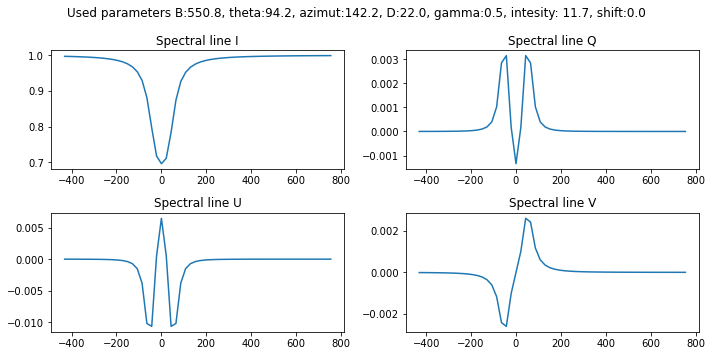

In [5]:
print("Вот здесь максимальное значение у интенсивности почти 1, потому что \n 7 и 8 параметр (источник и градиент) в сумме 1\n")
param_vec = test_params_1.copy()
for i in [6,7]:
    param_vec[i] = test_params_1[i]/np.sum(test_params_1[6:8])
lines0 = plot_lines(param_vec, with_ff=True, with_noise = False)
print(f'\n Максимум по линиям: {np.max(lines0):.2f}')
      

Вот здесь максимальное значение уже другое и равно должно быть сумме 7 и 8 параметра 1


 Максимум по линиям: 40686.48, сумма параметров 7 и 8 :40727.43


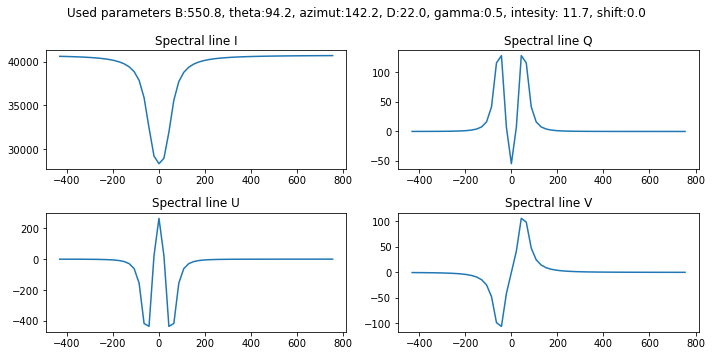

In [6]:
print("Вот здесь максимальное значение уже другое и равно должно быть сумме 7 и 8 параметра 1\n")
param_vec = test_params_1.copy()
lines1 = plot_lines(param_vec, with_ff=True, with_noise = False)
print(f'\n Максимум по линиям: {np.amax(lines1):.2f}, сумма параметров 7 и 8 :{np.sum(param_vec[6:8]):.2f}')


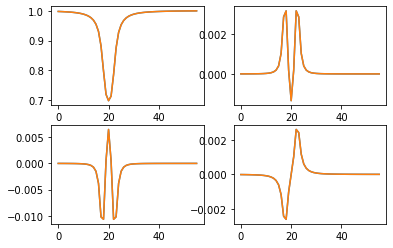

In [7]:
#если поделим их на максимумы и нарисуем то увидим что все 1 в 1 совпадает
lines0 = lines0 / np.amax(lines0)
lines1 = lines1 / np.amax(lines1)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(lines0[0,:,i])
    plt.plot(lines1[0,:,i])

###  Как мы готовим данные в сеть

мы запоминаем континум в отдельное значение, которое потом используем при обучении и генерим сразу нормированный датасет. Почему?
Ну так вроде сразу решили вопросы с нормировкой и показалось удобно. Проверим что все в порядке, в общем все в порядке



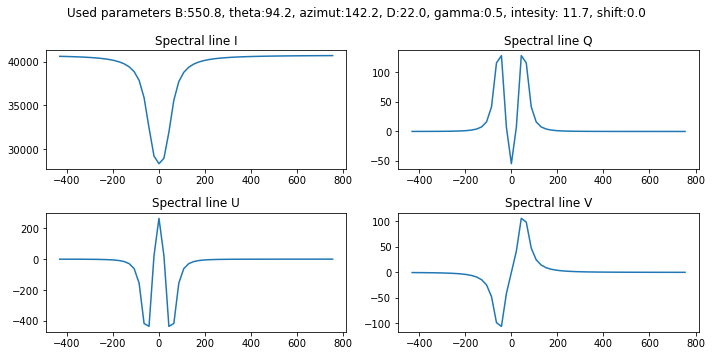

In [8]:
obj = HinodeME(test_params_1)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=False)
lines1 = plot_lines(test_params_1, with_ff=True, with_noise = False)

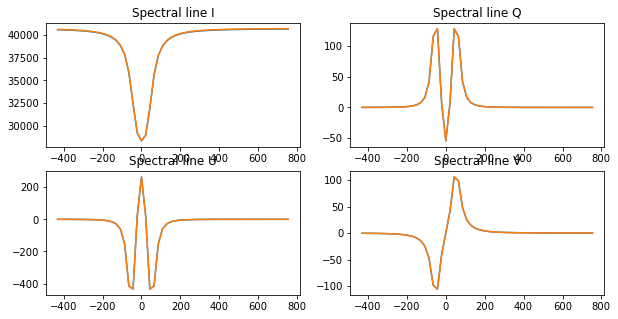

In [9]:
line_type = ['I','Q','U','V']
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(obj.line_arg, obj.cont*spectrum[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    ax[i//2][i%2].plot(obj.line_arg, lines1[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')



### !!!! Проверяем шум !!!!

У нас вот это такая штука, что добавляем случайный шум с такими сигмами к ненормированному спектру:
absolute_noise_levels=[109, 28, 28, 44]



 Максимум по линиям: 40914.97


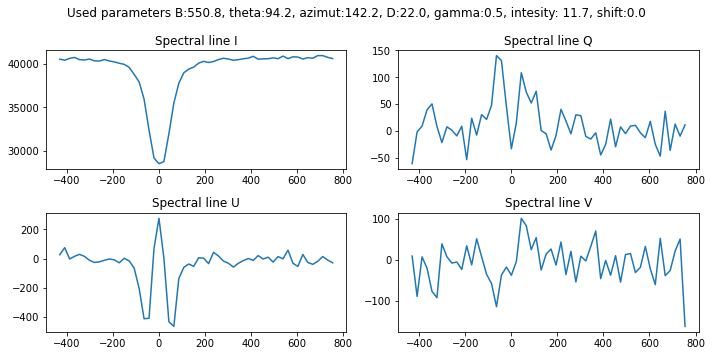

In [10]:
lines1 = plot_lines(test_params_1, with_ff=True, with_noise = True)
print(f'\n Максимум по линиям: {np.amax(lines1):.2f}')

In [11]:
obj = HinodeME(test_params_1)
spectrum = obj.compute_spectrum(with_ff=True, with_noise=True)     

Проверили что генератор совпадает с моделькой


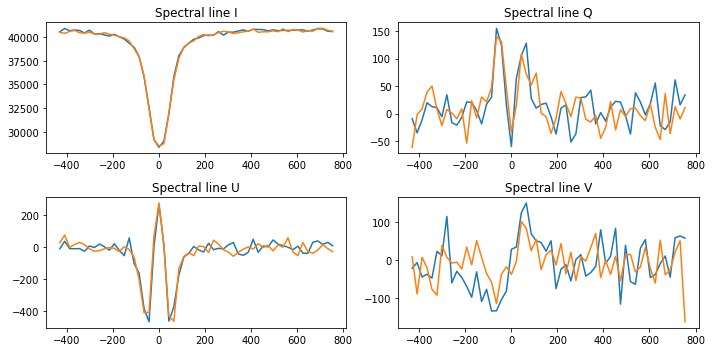

In [13]:
line_type = ['I','Q','U','V']
fig, ax = plt.subplots(2,2, figsize = (10,5))
for i in range(4):
    ax[i//2][i%2].plot(obj.line_arg, obj.cont*spectrum[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    ax[i//2][i%2].plot(obj.line_arg, lines1[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
    fig.set_tight_layout(tight = True)

print("Проверили что генератор совпадает с моделькой")

## LM
У Андрея в загруженной папочке все хорошо, но на старом коде, внутри нашей истории это будет выглядеть как-то так

In [15]:
#должны написать функцию для получаения чистого модельного профиля без шума
def me_lm_prepare(line_arg, *params):
   
    line_vec = (6302.5, 2.5, 1)
    param_vec = np.array([*params])
    lines = me_model(param_vec, line_arg, line_vec, with_ff=True, with_noise= False, norm = False)
    return lines.reshape(1,-1, order='F').flatten()
def generate_real_lines_vs_model(param_vec, plot_show = True):
    """
    Help function for plot results of me_model reconstruction from parameters
    """
    line_vec = (6302.5, 2.5, 1)
    line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - line_vec[0])

    
    real_lines = me_model(param_vec, line_arg, line_vec, with_ff=True, with_noise=True, norm = False)
    model_lines = me_lm_prepare(line_arg, *param_vec)

    if plot_show:

        line_type = ['I','Q','U','V']

        fig, ax = plt.subplots(2,2, figsize = (10,5))
        for i in range(4):
            ax[i//2][i%2].plot(line_arg, real_lines[0,:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')
            ax[i//2][i%2].plot(line_arg, model_lines.reshape(56,4, order = 'F')[:,i]); ax[i//2][i%2].set_title(f'Spectral line {line_type[i]}')

        fig.set_tight_layout(tight = True)
        fig.suptitle(f'Used parameters B:{param_vec[0]:.1f}, theta:{param_vec[1]:.1f}, azimut:{param_vec[2]:.1f}, D:{param_vec[3]:.1f}, gamma:{param_vec[4]:.1f}, intesity: {param_vec[5]:.1f}, shift:{param_vec[8]:.1f}')
    return real_lines.reshape(1,-1, order='F').flatten(), model_lines


### Включаем оптимизатор, итерационный алгоритм
нам надо задать стартовую точку, ограничения на параметры, функцию для модели атмосферы, x  и реальные данные

In [16]:
# выход out[0] - оценка, out[1] - дисперсия

def predict_one_pixel(param_vec, plot_show = False):
    start = time.time()
    real_lines, model_lines = generate_real_lines_vs_model(param_vec, plot_show = plot_show)
    start_mean =  [530, 91, 89, 33, 0.31, 12, 27083, 19567, 0.04, 0.5, 0.36]
    max_ = [5000, 180, 180, 90, 1.5, 100, 38603, 60464, 10, 1, 10]
    min_ = [0, 0, 0, 20, 0, 0.01, 0, 0, -10, 0, -10]
    bounds = (min_, max_)
    line_arg = 1000 * (np.linspace(6302.0692255, 6303.2544205, 56) - 6302.5)
    try:
        out = curve_fit(me_lm_prepare, xdata = line_arg, ydata = real_lines, bounds = (min_, max_), p0 = start_mean)
    except:
        out=(start_mean, np.zeros(11, 11))
    
    elapsed = (time.time() - start)
    print(f"Время обсчета одного пикселя {elapsed:.2f} секунд, а снимка: {512*873*elapsed/3600:.2f} часов")
    pcov = out[1]
    perr = np.sqrt(np.diag(pcov))
    data = np.concatenate([param_vec.reshape(11,-1), out[0].reshape(11,-1), perr.reshape(11,-1)], axis=1)
    df = pd.DataFrame(data, columns = ['target', 'predicted', 'sigmas'])
    return out, df

Время обсчета одного пикселя 0.99 секунд, а снимка: 123.30 часов


,target,predicted,sigmas
0,550.76,345.25,71.02
1,94.18,92.25,0.81
2,142.19,142.78,1.73
3,21.96,23.56,0.70
4,0.51,0.54,0.03
5,11.73,8.46,1.16
6,26329.90,25455.19,479.03
7,14397.53,15247.06,476.54
8,0.01,-0.01,0.05
9,0.37,0.87,0.33


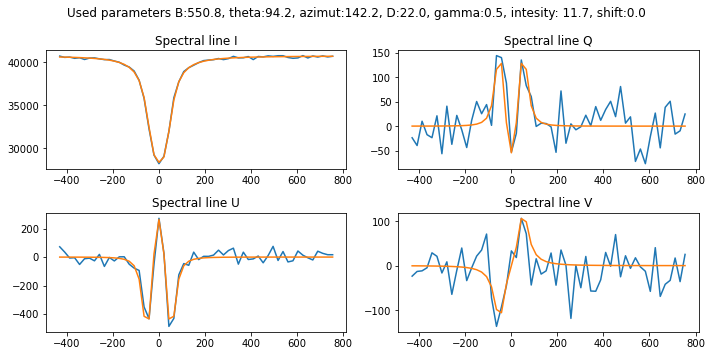

In [17]:
out,df = predict_one_pixel(test_params_1, plot_show=True)
df.round(2)

Время обсчета одного пикселя 0.41 секунд, а снимка: 51.16 часов


,target,predicted,sigmas
0,4.50,27.87,98.15
1,180.00,180.00,39437586.86
2,52.71,180.00,4.81
3,35.06,35.97,0.94
4,0.19,0.22,0.02
5,11.48,9.52,1.48
6,29931.16,29468.49,526.93
7,26170.47,26635.74,524.83
8,-1.41,0.30,0.99
9,0.39,0.06,0.13


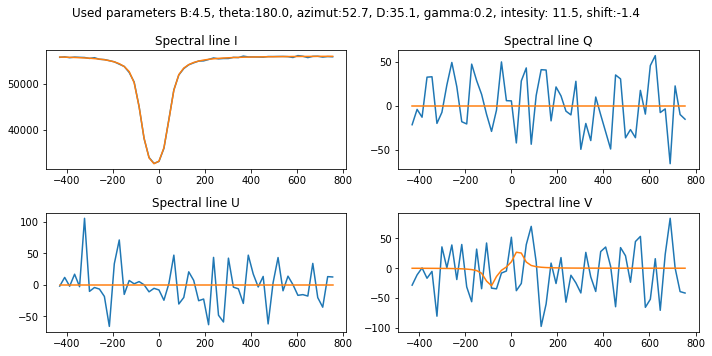

In [19]:
out,df = predict_one_pixel(test_params_0, plot_show = True)
df.round(2)

## Осталось сделать!
 - Взять реферер и для каждой точки посчитать инверсию с ошибками со стартом из среднего (запоминать время)
 - Взять реферер и то же самое, но со стартом из нейропрогноза 
 - Сделать то же самое для реальных спектров